# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including LlamaIndex and LangChain, however, the goal of building from scratch is to be able to inspect and customize all the parts.

# What is RAG?

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper  [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks.](https://arxiv.org/abs/2005.11401)

Each step can be roughly broken down to:

Retrieval - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.    
Augmented - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).    
Generation - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.   

# Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

Two Primary improvements can be seen as:
1.Preventing Hallucinations: LLMs are incredible but they are prone to potential hallucinations as in generating something that looks correct but it isn't.RAG pipelines can help LLMs generate more factual outputs by providing them with the factual (retrived) inputs. and even if the generated answer from RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
2.Work with custom data : Many base LLMs are trained with internet scale text data. This means they have great ability to model language, however they often lack specific knowldge. RAG systems can provide LLMs with domain specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.

RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data.

# What kind of problems can RAG be used for?

RAG can help anywhere there is a specific set of information that an LLM may not have in its training data (e.g. anything not publicly accessible on the internet).

For example you could use RAG for:

Customer support Q&A chat - By treating your existing customer support documentation as a resource, when a customer asks a question, you could have a system retrieve relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation". Klarna, a large financial company, uses a system like this to save $40M per year on customer support costs.
Email chain analysis - Let's say you're an insurance company with long threads of emails between customers and insurance agents. Instead of searching through each individual email, you could retrieve relevant passages and have an LLM create strucutred outputs of insurance claims.
Company internal documentation chat - If you've worked at a large company, you know how hard it can be to get an answer sometimes. Why not let a RAG system index your company information and have an LLM answer questions you may have? The benefit of RAG is that you will have references to resources to learn more if the LLM answer doesn't suffice.
Textbook Q&A - Let's say you're studying for your exams and constantly flicking through a large textbook looking for answers to your quesitons. RAG can help provide answers as well as references to learn more.
All of these have the common theme of retrieving relevant resources and then presenting them in an understandable way using an LLM.

From this angle, you can consider an LLM a calculator for words.

# Why local?

Privacy, speed, cost.

Running locally means you use your own hardware.

From a privacy standpoint, this means you don't have send potentially sensitive data to an API.

From a speed standpoint, it means you won't necessarily have to wait for an API queue or downtime, if your hardware is running, the pipeline can run.

And from a cost standpoint, running on your own hardware often has a heavier starting cost but little to no costs after that.

Performance wise, LLM APIs may still perform better than an open-source model running locally on general tasks but there are more and more examples appearing of smaller, focused models outperforming larger models.

# What we're going to build

We are going to build RAG pipeline which enables us to chat with a PDF document.

We will write the code toL
1.Open a PDF document
2.Format the text of the PDF ready for an embedding model(this process is known as text splitting/chunking)
3.Embed all of the chunks of text in the pdf and turn them into numerical representation which we can store for later.
4.Build a retrival system that uses vector search to find relevant chunks of the text based on a query.
5.Create a prompt that incorporates the retrieved pieces of text.
6.Generate an answer to a query on passages from the textbook.

The above steps can be broken down into two major sections:
1. Document preprocessing/embedding creation ( Step 1-3)
2. Search and answer(steps 4-6)

It's similar to the workflow outlined on the NVIDIA blog which details a local RAG pipeline. https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/

# Requirements and setup

In [ ]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash-attn


# 1. Document/Text Processing and Embedding Creation

Ingredients:

1.   PDF document of choice
2.   Embedding mode of choice

Steps:

Import PDF document.

1.   Process text for embedding (e.g. split into chunks fo sentences)
2.   Embed text chunks with embedding model.
3.   Save embeddings to file for later use(embeddings will store on file for many years or until you lose your hard drive)


### **Import PDF Document**

This will work with many other kinds of documents.

However, we'll start with PDF since many people have PDFs.

But just keep in mind, text files, email chains, support documentation, articles and more can also work.

There are several libraries to open PDFs with Python but I found that PyMuPDF works quite well in many cases.

First we'll download the PDF if it doesn't exist.

In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (import fitz).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [ ]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Now let's get a random sample of the pages.

In [ ]:
import random

random.sample(pages_and_texts,k=3)

[{'page_number': 1041,
  'page_char_count': 84,
  'page_word_count': 16,
  'page_sentence_count_raw': 3,
  'page_token_count': 21.0,
  'text': 'PART\xa0XVIII  CHAPTER 18.  NUTRITIONAL ISSUES  Chapter 18. Nutritional Issues  |  1041'},
 {'page_number': 624,
  'page_char_count': 1160,
  'page_word_count': 207,
  'page_sentence_count_raw': 8,
  'page_token_count': 290.0,
  'text': 'at once to get the RDA of calcium.  Dietary Reference Intake for Calcium  The recommended dietary allowances (RDA) for calcium are listed  in Table 10.1 “Dietary Reference Intakes for Calcium”. The RDA is  elevated to 1,300 milligrams per day during adolescence because  this is the life stage with accelerated bone growth. Studies have  shown that a higher intake of calcium during puberty increases  the total amount of bone tissue that accumulates in a person. For  women above age fifty and men older than seventy-one, the RDAs  are also a bit higher for several reasons including that as we age,  calcium absorpti

### **Get some stats on the text**

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the sentence-transformers model all-mpnet-base-v2 has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

We'll discuss this more in the embedding section.

For now, let's turn our list of dictionaries into a DataFrame and explore it.

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the all-mpnet-base-v2 model (this model has an input capacity of 384).

###  **Further text processing (splitting pages into sentences)**



The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings

Some options for splitting text into sentences:

Split into sentences with simple rules (e.g. split on ". " with text = text.split(". "), like we did above).
Split into sentences with a natural language processing (NLP) library such as spaCy or nltk.
Why split into sentences?

Easier to handle than larger pages of text (especially if pages are densely filled with text).
Can get specific and find out which group of sentences were used to help within a RAG pipeline.
Resource: See spaCy install instructions.

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using text.split(". ").

In [ ]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 915,
  'page_char_count': 1658,
  'page_word_count': 269,
  'page_sentence_count_raw': 12,
  'page_token_count': 414.5,
  'text': 'the dietary guidelines in the middle-aged years provides adequate  but not excessive energy, macronutrients, vitamins, and minerals.  The AMDRs for carbohydrates, protein, fat, fiber, and fluids  remain the same from young adulthood into middle age. It is  important to avoid putting on excess pounds and limiting an intake  of SoFAAS to help avoid cardiovascular disease, diabetes, and other  chronic conditions.  Micronutrients  There are some differences, however, regarding micronutrients. For  men, the recommendation for magnesium increases to 420  milligrams daily, while middle-aged women should increase their  intake of magnesium to 320 milligrams per day. Other key vitamins  needed during the middle-aged years include folate and vitamins  B6 and B12 to prevent elevation of homocysteine, a byproduct of  metabolism  that  can  damage  arte

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


For our set of text, it looks like our raw sentence count (e.g. splitting on ". ") is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we group those sentences?

### **Chunking our sentences together**


Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as chunking.

Why do we do this?

Easier to manage similar sized chunks of text.
Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.
Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our all-mpnet-base-v2 model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 52,
  'page_char_count': 766,
  'page_word_count': 125,
  'page_sentence_count_raw': 5,
  'page_token_count': 191.5,
  'text': 'usage.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=65  \xa0 52  |  Types of Scientific Studies',
  'sentences': ['usage.',
   ' Learning Activities  Technology Note: The seco

In [ ]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### **Splitting each chunk into its own item**


We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 961,
  'sentence_chunk': 'Macronutrient Needs The composition of macronutrients in the diet is a key factor in maximizing performance for athletes. Carbohydrates are an important fuel source for the brain and muscle during exercise. \xa0Carbohydrate storage in the liver and muscle cells are relatively limited and therefore it is important for athletes to consume enough carbohydrates from their diet. Carbohydrate needs should increase about 3-10 g/kg/day depending on the type of training or competition.3 See Table 16.1 “Daily Needs for Carbohydrate Fuel” for carbohydrate needs for athletes depending on the intensity of the exercise. Table 16.1 Daily Needs for Carbohydrate Fuel Activity Level Example of Exercise Increase of Carbohydrate (g/kg of athlete’s body weight/ day) Light Low intensity or skill based activities 3-5 Moderate Moderate exercise program (about 1 hour per day) 5-7 High Endurance program (about 1-3 hours per day of moderate to high intensity exercise) 6

Excellent!

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [ ]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 26.5 | Text: It is stored in the rectum until it is expelled through the anus via defecation. The Digestive System | 77
Chunk token count: 29.25 | Text: Abagovomab (monoclonal antibody) by Blake C / CC BY-SA 3.0 Figure 6.13 Antigens Protein’s Functions in the Body | 389
Chunk token count: 24.25 | Text: These activities are available in the web-based textbook and not available in the Magnesium | 643
Chunk token count: 3.25 | Text: 814 | Infancy
Chunk token count: 16.25 | Text: Health Consequences and Benefits of High-Carbohydrate Diets | 267


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

Smaller chunks filtered!

Time to embed our chunks of text!

### **Embedding our text chunks**

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

But one of my favourite and simple definitions is "a useful numerical representation".

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use our computers to find patterns in the embeddings and then we can use their text mappings to further our understanding.

Enough talking, how about we import a text embedding model and see what an embedding looks like.

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [ ]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

How about we do just once sentence?

In [ ]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447427e-02 -4.51086881e-03 -4.98485053e-03  6.55445009e-02
 -9.87679232e-03  2.72835400e-02  3.66426297e-02 -3.30218766e-03
  8.50079488e-03  8.24953429e-03 -2.28496902e-02  4.02430221e-02
 -5.75200692e-02  6.33693114e-02  4.43207026e-02 -4.49507199e-02
  1.25284074e-02 -2.52012592e-02 -3.55292559e-02  1.29559208e-02
  8.67017172e-03 -1.92917418e-02  3.55633581e-03  1.89505871e-02
 -1.47128394e-02 -9.39850323e-03  7.64166377e-03  9.62190889e-03
 -5.98926842e-03 -3.90170179e-02 -5.47824502e-02 -5.67451864e-03
  1.11644585e-02  4.08067852e-02  1.76319122e-06  9.15295724e-03
 -8.77268612e-03  2.39383057e-02 -2.32784506e-02  8.04999471e-02
  3.19177508e-02  5.12592029e-03 -1.47708794e-02 -1.62525047e-02
 -6.03212789e-02 -4.35689688e-02  4.51210849e-02 -1.79053862e-02
  2.63366923e-02 -3.47867236e-02 -8.89174361e-03 -5.47675230e-02
 -1.24372840e-02 -2.38606390e-02  8.33497047e-02  5.71242571e-02
  1.13328639e-02 -1.49595207e-02  9.2037

We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [ ]:
%%time
# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 32.1 s, sys: 514 ms, total: 32.6 s
Wall time: 34 s


In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
text_chunks[0]

'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE'

In [ ]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 22.8 s, sys: 48.8 ms, total: 22.8 s
Wall time: 23.3 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

Now let's save our chunks and their embeddings so we could import them later if we wanted.

###  **Save embeddings to file**

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [ ]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

NameError: name 'pd' is not defined

# 2. RAG - Search and Answer

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How?

It starts with better search.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

If this sounds like woo, woo. It's not.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "apple" with the string "apple".

Whereas with similarity/semantic search, you may want to search "macronutrients functions".

And get back results that don't necessarily contain the words "macronutrients functions" but get back pieces of text that match that meaning.

> **Example:** Using similarity search on our textbook data with the query "macronutrients function" returns a paragraph that starts with:
>
>*There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.*
>
> as the first result. How cool!

If you've ever used Google, you know this kind of workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor

In [1]:
import random

import torch
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv('text_chunks_and_embeddings_df.csv')

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df['embedding'].tolist()),dtype=torch.float32).to(device)

embeddings.shape

torch.Size([1680, 768])

In [ ]:
text_chunks_and_embeddings_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


Now let's prepare another instance of our embedding model. Not because we have to but because we'd like to make it so you can start the notebook from the cell above.

In [2]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model ready!

Time to perform a semantic search.

Let's say you were studying the macronutrients.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:

Define a query string (e.g. "macronutrients functions") - note: this could be anything, specific or not.
Turn the query string in an embedding with same model we used to embed our text chunks.
Perform a dot product or cosine similarity function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.
Easy!

In [3]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.02262 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

~0.02632 seconds to perform a dot product comparison across 1680 embeddings on T4 GPU

GPUs are optimized for these kinds of operations.

So even if you we're to increase our embeddings by 100x (1680 -> 168,000), an exhaustive dot product operation would happen in ~0.2 seconds (assuming linear scaling).

Heck, let's try it.

In [4]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00112 seconds.


That means we can get pretty far by just storing our embeddings in torch.tensor for now.

However, for much larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as Faiss.

Let's check the results of our original similarity search.

torch.topk returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the embeddings tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [5]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the top_results_dot_product tuple and match up the scores and indicies and then use those indicies to index on our pages_and_chunks variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [6]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

The first result looks to have nailed it!

We get a very relevant answer to our query "macronutrients functions" even though its quite vague.

That's the power of semantic search!

And even better, if we wanted to inspect the result further, we get the page number where the text appears.

In [7]:
%%capture
!pip install PyMuPDF

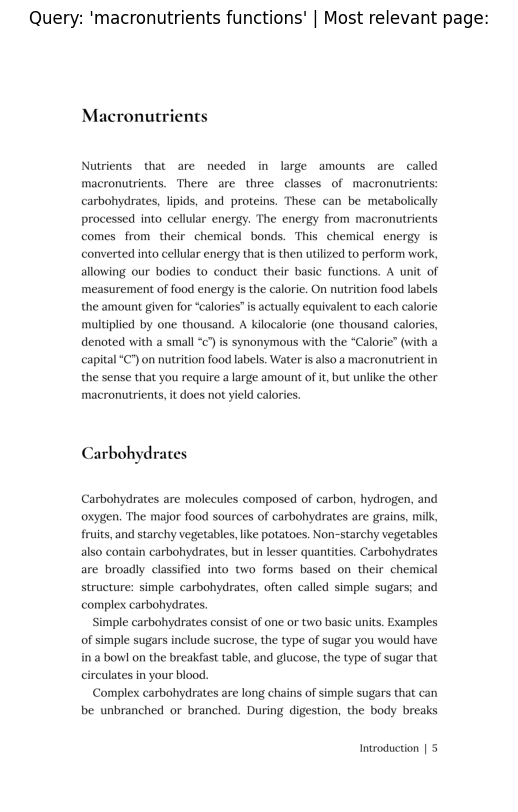

In [8]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

The workflow is the same:

ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings

## **Functionizing our semantic search pipeline**

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [9]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")


In [10]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00326 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [11]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th

## **Getting an LLM for local generation**

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

We'll augment our prompt with a query as well as context from our textbook related to that query.

Which LLM should I use?

There are many LLMs available.

Two of the main questions to ask from this is:

Do I want it to run locally?
If yes, how much compute power can I dedicate?

To find open-source LLMs, one great resource is the : https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard#/

## Checking local GPU memory availability

In [12]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


let's write a simple if/else statement which recommends which Gemma variant we should look into using.

In [13]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


## **Loading an LLM locally**

To load our LLM, we're going to need a few things:

A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the transformers.BitsAndBytesConfig class (requires installing the bitsandbytes library).  
A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example gemma-7b-it.  
A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the transformers.AutoTokenzier.from_pretrained method and passing it our model ID.  
An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the transformers.AutoModelForCausalLM.from_pretrained method and passing it our model ID as well as other various parameters.  

In [14]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash-attn


In [ ]:
#setting model to llama as Gemma approval is pending.

#model_id ='meta-llama/Llama-2-7b-chat-hf'
#use_quantization_config = False

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig

#4-Bit config
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                        bnb_4bit_compute_dtype=torch.float16)

#8-Bit Config
#quantization_config = BitsAndBytesConfig( load_in_8bit=True,
#                                         bnb_8bit_compute_dtype=torch.float16 )

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=True, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

We've got an LLM!

Let's check it out.

In [16]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [17]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_wor

How about we get the number of parameters in our model?

In [18]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

its around ~7B parameters

How about we get the models memory requirements?

In [19]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

## **Generating text with our LLM**

We can generate text with our LLM model instance by calling the generate() method (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our tokenizer.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the meta-llama/Llama-2-7b-chat-hf model has been trained in a dialogue fashion (instruction tuning).

To get the expected features and performance for the chat versions, a specific formatting needs to be followed, including the INST and <<SYS>> tags, BOS and EOS tokens, and the whitespaces and breaklines in between (we recommend calling strip() on inputs to avoid double-spaces)

In this case, our tokenizer has a apply_chat_template() method which can prepare our input text in the right format for the model.

In [20]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



Our next step is to tokenize this formatted text and pass it to our model's generate() method.

We'll make sure our tokenized text is on the same device as our model (GPU) using to("cuda").

Let's generate some text!

We'll time it for fun with the %%time magic.

In [21]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,    108,   

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using tokenizer.decode().

In [22]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
  

But notice how the output contains the prompt text as well?

How about we do a little formatting to replace the prompt in the output text?

In [23]:
print(f"Input text: {input_text}\n")
#This is for Lllama 3
#print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('[INST]', '').replace('[/INST]', '').replace('<s>', '')}")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the r

We just officially generated text from an LLM running locally.

So we've covered the R (retrieval) and G (generation) of RAG.

How about we check out the last step?

Augmentation.

First, let's put together a list of queries we can try out with our pipeline.

In [24]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

And now let's check if our retrieve_relevant_resources() function works with our list of queries.

In [25]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on 1680 embeddings: 0.00010 seconds.


(tensor([0.5964, 0.5766, 0.5745, 0.5707, 0.5600], device='cuda:0'),
 tensor([1548,  360,  373,  380,  379], device='cuda:0'))

## **Augmenting our prompt with context items**

In [26]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [27]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How often should infants be breastfed?
[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and

What a good looking prompt!

We can tokenize this and pass it straight to our LLM.

In [28]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How often should infants be breastfed?
RAG answer:
<bos>The passage does not specify the frequency at which infants should be breastfed, so I cannot answer this question from the provided context.<eos>
CPU times: user 1.19 s, sys: 8.09 ms, total: 1.2 s
Wall time: 1.22 s


Next Step - Reload the model in 8bit quantization due to out of memory error while doing inference.

In [29]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitam

We can tokenize this and pass it straight to our LLM.

In [30]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Explain the concept of energy balance and its importance in weight management.
RAG answer:
<bos>Sure, here's the relevant passage from the context:

> Energy balance is achieved when intake of energy is equal to energy expended. In a positive energy balance, excess nutrient energy will be stored or used to grow. In a negative energy balance, the body will use its stores to provide energy.<eos>
CPU times: user 2.21 s, sys: 0 ns, total: 2.21 s
Wall time: 2.21 s


Our RAG pipeline is complete!

We just Retrieved, Augmented and Generated!

And all on our own local GPU!

How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.

In [31]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

The workflow could probably be a little refined but this should work!

Let's try it out.

In [32]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00030 seconds.
Answer:

**Concept of Energy Balance** Energy balance is the state in which the intake of
energy is equal to the expenditure of energy. This means that the body does not
experience a net change in energy, and any excess energy is stored or used for
various physiological processes. In a negative energy balance, the body burns
more energy than it takes in, leading to weight loss. Conversely, a positive
energy balance results in the body consuming more energy than it takes in,
leading to weight gain.  **Importance of Energy Balance for Weight Management**
Maintaining energy balance is crucial for weight management. When a person is in
a positive energy balance, their body utilizes stored energy and utilizes
nutrients and oxygen efficiently, leading to weight maintenance. Conversely,
when the body is in a negative energy balance, it burn

[{'page_number': 476,
  'sentence_chunk': 'Photo by Jon Flobrant on unsplash.co m / CC0 https://unspl ash.com/ photos/_r19 nfvS3wY Balancing Energy Input with Energy Output To Maintain Weight, Energy Intake Must Balance Energy Output Recall that the macronutrients you consume are either converted to energy, stored, or used to synthesize macromolecules. A nutrient’s metabolic path is dependent upon energy balance. When you are in a positive energy balance the excess nutrient energy will be stored or used to grow (e.g., during childhood, pregnancy, and wound healing). When you are in negative energy balance you aren’t taking in enough energy to meet your needs, so your body will need to use its stores to provide energy. Energy balance is achieved when intake of energy is equal to energy expended. Weight can be thought of as a whole body estimate of energy balance; body weight is maintained when the body is in energy balance, lost when it is in negative energy balance, and gained when it 

Local RAG workflow complete!

We've now officially got a way to Retrieve, Augment and Generate answers based on a source.

For now we can verify our answers manually by reading them and reading through the textbook.

But if you want to put this into a production system, it'd be a good idea to have some kind of evaluation on how well our pipeline works.

For example, you could use another LLM to rate the answers returned by our LLM and then use those ratings as a proxy evaluation.